# ACCY 571 Group Project  

## Overview 
-----

### Goal   

Complete a data analytics project that demonstrates your mastery of the course content.
  
  1.  Demonstrate the ability to apply machine learning and data analytics concepts from ACCY 570 to summarize data and to produce insightful visualizations.
  2.  Show that you can interact with a SQL database to extract relevant data.
  3.  Show that you can use text and network analyses to extract key insights from a rich data set.
  
### Prompt  

Your boss at Goliath National Bank sends you the frustratingly vague directive:

> We're interested in funding the development of new businesses such as 
> - restaurants,  
> - coffee shops, and  
> - bars
>  
> in the far off land of ____, but we need your team to 
> **get a better picture of the consumers** before we get make any investments.  

Your task is to pick a region or city and use the provided yelp database to characterize the eating/spending habits of of the resident consumers. Your boss hasn't specified exactly what she is expecting you to find, so it is up to you best figure out how to determine the best location.

-----

  
## Criteria
-----

You will work in groups of __4-5__ students to analyze the provided **Yelp** data set to make a recommendation,
based on the features present in this database.

You will complete three tasks for this group project:
1. A group report in the form of a Jupyter notebook,
2. An in-class presentation where your group will present your results, and 
3. Peer evaluation of the contributions of each member of your group.

Your final group report will be a single Jupyter notebook that will integrate Markdown, Python code, and the results from your code, such as data visualizations. Markdown cells should be used to explain any decisions you make regarding the data, to discuss any plots or visualizations generated in your notebook, and the results of your analysis. As a general guideline, the content should be written in a way that a fellow classmate (or an arbitrary data scientist/analyst) should be able to read your report and understand the results, implications, and processes that you followed to achieve your result. If printed (not that you should do this), your report should be at least fifteen pages.

Your group will present the material in-class in a format that is left up to each group. For example, you can use presentation software such as MS Powerpoint, PDFs, your Notebook, or Prezi, or, alternatively, you can choose some other presentation style (feel free to discuss your ideas with the course staff). The presentations should cover all steps in your analytics process and highlight your results. The presentation should take between eight to twelve minutes, and will be graded by your discussion teaching assistant.

### Rubric
  - Notebook Report (40%)
  - Class presentation (40%)
  - Peer assessment from your group-mates (20%)

### General

Your report should 
  1. use proper markdown, 
  2. include all of the code used for your analysis,
  3. include properly labeled plots (e.g., use axis labels and titles),
  4. use a consistent style between graphs, and
  5. be entirely the work of your own group, **Do not plagiarize code, this includes anything you might find online**.
  
All code should be written by you and your group.

-----

### Exploratory Data Analysis (EDA)

When exploring the database to determine how to pick the best location (and optionally what type of business or businesses to launch), some ideas to consider are:

- What types of restaurants are most popular and where?  
  - Can we predict the rating of different types of restaurants? 
  - How does your city compare to other major cities or nearby towns? 
  - I.e. do coffee shops fair better in Champaign than elsewhere?
- What can be learned from the review text itself? 
  - Whats the sentiment towards different types of eateries? 
  - What are reviewers talking about the most?
- Do users who visit one business tend to visit certain other businesses? 
  - I.e. do people who like seven saints tend to like _Distihl_? What about their friends?
- Is the restaurant selection diverse or homogenous? 
  - Are there a lot of a few types of restaurants? 
  - Has this been changing over time? 
  - Is there a demand for more types of food?
- How much does location matter? 
  - Are there central hubs where restaurants tend to do well in the reviews?

These questions are __NOT__ meant to be comprehensive, they are useful starting points. You should try to answer at least three major questions and at least one new question that your group comes up with on their own (i.e. not on the previous list).

-----

## Objectives

### Exposition

1. Break the overarching question **_What are consumer's eating habits?_**' into at least 3 smaller sub-questions. 
2. Explain how answering these contributes to answering the overarching question.

### Pull and Process Data

1. Use the yelp database to construct datasets to be used in your analysis.
2. Create features, preprocess, normalize, cluster, reduce dimensions, etc. as necessary.

### Analysis

For each of the questions your group decides to answer, approach them in the following manner:

1. Question 1
   1. Use graphs, machine learning, data aggregation, or anything else needed to answer the question
2. Question 2
   1. Use graphs, machine learning, data aggregation, or anything else needed to answer the question
3. Question 3
   1. Use graphs, machine learning, data aggregation, or anything else needed to answer the question
3. Question 4
   1. Use graphs, machine learning, data aggregation, or anything else needed to answer the question


-----

### Conclusion

Summarize your results, in plain english, as if this is the only part your boss will read. Note your boss is intelligent but has no interest in code or model output, she is only interested in words, pictures, and metrics.

-----

## Notes

- Completing the objectives will most likely __NOT__ proceed linearly. Querying data and subsequently analyzing these data will lead to new insights, which will mean extracting more data and performing new analyses. This entire process will also  influence the types of questions you can ask/answer.
- The overall [Database schematic][dbs] is available showing the data and their inherent relationships. This should be a starting point for your queries.
  - Note, we have not included the photo dataset, this keeps the data volume to a reasonable size.
- There is no unique solution to this project, each group should develop a different approach, analysis pipeline, and result.
- Your group should have fun with this! This is an open-ended project, which will be similar to what you face next semester in ACCY 575, and in the real world. The Yelp datasets contain a great deal of very interesting information, this is a chance for you to demonstrate to the class your mastery of the subject material, you should have fun exploring.

-----

[dbs]: https://s3-media2.fl.yelpcdn.com/assets/srv0/engineering_pages/9c5f7a89fd08/assets/img/dataset/yelp_dataset_schema.png

# Part 1 What types of restaurants are most popular and where?

In [1]:
import sqlite3 as sql
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# sqlite std: https://www.alexforencich.com/wiki/en/scripts/python/stdev
class StdevFunc:
    """
    For use as an aggregate function in SQLite
    """
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 0

    def step(self, value):
        try:
            # automatically convert text to float, like the rest of SQLite
            val = float(value) # if fails, skips this iteration, which also ignores nulls
            tM = self.M
            self.k += 1
            self.M += ((val - tM) / self.k)
            self.S += ((val - tM) * (val - self.M))
        except:
            pass

    def finalize(self):
        if self.k <= 1: # avoid division by zero
            return none
        else:
            return math.sqrt(self.S / (self.k-1))

def query(q):
    """
    Function that query the database and return the dataframe
    """
    with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
        con.create_aggregate("stdev", 1, StdevFunc)
        df = pd.read_sql(q, con)
    return df

def convert_df_to_vector(df):
    """
    Function that convert a dataframe and return a vector of integer
    """
    return df.as_matrix().flatten().astype(int)

### 1.1 Can we predict the rating of different types of restaurants?

Let's compare restaurants for same properties but only different types

In [2]:
df = query('''
select
  category.category, review.stars
from
  business
left join category
  on business.id = category.business_id
left join review
  on business.id = review.business_id
where
  business.city in ("Champaign", "Urbana")
  and
  category.category in ("American (New)", "American (Traditional)")
''')

df.head()

,category,stars
0,American (Traditional),2
1,American (Traditional),4
2,American (Traditional),4
3,American (Traditional),3
4,American (Traditional),2


In [3]:
# Process data for analyze
new = convert_df_to_vector(df[df.category == 'American (New)']['stars'])
traditional = convert_df_to_vector(df[df.category == 'American (Traditional)']['stars'])
new

array([5, 4, 5, ..., 2, 2, 1])

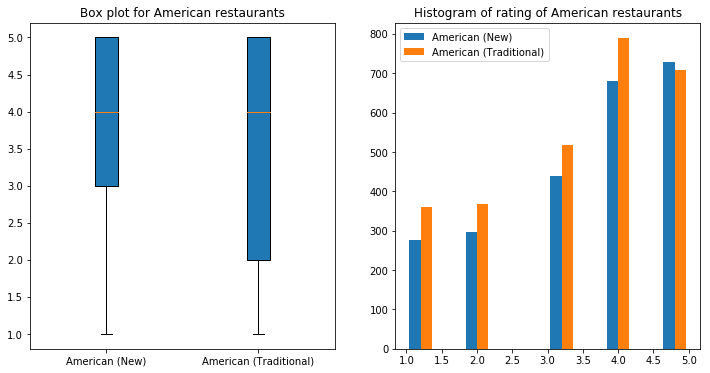

In [4]:
all_data = [new, traditional]
labels = ['American (New)', 'American (Traditional)']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].boxplot(all_data, vert=True, patch_artist=True)
axes[0].set_xticklabels(labels)
axes[0].set_title('Box plot for American restaurants')

axes[1].hist(all_data, label=labels)
axes[1].legend()
axes[1].set_title('Histogram of rating of American restaurants')

plt.show()

### Analysis

It obvious that the two types of American restaurants have similar median of rating, but traditional American restaurant has larger deviation, which means part of people have more complaint on traditional American restaurant than the new American restaurant. The histogram illustrates the same fact because the lower rating for traditional American restaurant has a larger amount than the new American restaurant.

We could also compare all the restaurant types in Champaign

In [5]:
# pull data and calculate the average from the database
df = query('''
select
  category.category,
  count(review.stars) as `count`,
  avg(review.stars) as `avg`,
  stdev(review.stars) as `std`
from
  business
left join category
  on business.id = category.business_id
left join review
  on business.id = review.business_id
where
  business.city in ("Champaign", "Urbana")
  and
  category.category in ("Afghan", "African", "Senegalese", "South African", "American", "American", "Arabian", "Argentine", "Armenian", "Asian Fusion", "Australian", "Austrian", "Bangladeshi", "Barbeque", "Basque", "Belgian", "Brasseries", "Brazilian", "Breakfast & Brunch", "British", "Buffets", "Burgers", "Burmese", "Cafes", "Themed Cafes", "Cafeteria", "Cajun/Creole", "Cambodian", "Caribbean", "Dominican", "Haitian", "Puerto Rican", "Trinidadian", "Catalan", "Cheesesteaks", "Chicken Shop", "Chicken Wings", "Chinese", "Cantonese", "Dim Sum", "Hainan", "Shanghainese", "Szechuan", "Comfort Food", "Creperies", "Cuban", "Czech", "Delis", "Diners", "Dinner Theater", "Ethiopian", "Fast Food", "Filipino", "Fish & Chips", "Fondue", "Food Court", "Food Stands", "French", "Mauritius", "Reunion", "Game Meat", "Gastropubs", "German", "Gluten-Free", "Greek", "Guamanian", "Halal", "Hawaiian", "Himalayan/Nepalese", "Honduran", "Hong Kong Style Cafe", "Hot Dogs", "Hot Pot", "Hungarian", "Iberian", "Indian", "Indonesian", "Irish", "Italian", "Calabrian", "Sardinian", "Sicilian", "Tuscan", "Japanese", "Conveyor Belt Sushi", "Izakaya", "Japanese Curry", "Ramen", "Teppanyaki", "Kebab", "Korean", "Kosher", "Laotian", "Latin American", "Colombian", "Salvadoran", "Venezuelan", "Live/Raw Food", "Malaysian", "Mediterranean", "Falafel", "Mexican", "Tacos", "Middle Eastern", "Egyptian", "Lebanese", "Modern European", "Mongolian", "Moroccan", "New Mexican Cuisine", "Nicaraguan", "Noodles", "Pakistani", "Pan Asian", "Persian/Iranian", "Peruvian", "Pizza", "Polish", "Pop-Up Restaurants", "Portuguese", "Poutineries", "Russian", "Salad", "Sandwiches", "Scandinavian", "Scottish", "Seafood", "Singaporean", "Slovakian", "Soul Food", "Soup", "Southern", "Spanish", "Sri Lankan", "Steakhouses", "Supper Clubs", "Sushi Bars", "Syrian", "Taiwanese", "Tapas Bars", "Tapas/Small Plates", "Tex-Mex (tex-mex)", "Thai", "Turkish", "Ukrainian", "Uzbek", "Vegan", "Vegetarian", "Vietnamese", "Waffles", "Wraps")
group by
  category.category;
''')

df.head()

,category,count,avg,std
0,African,47,2.659574,1.478492
1,Arabian,90,4.355556,0.915670
2,Argentine,3,4.000000,1.732051
3,Asian Fusion,1118,3.509839,1.357822
4,Barbeque,1544,4.011658,1.260032


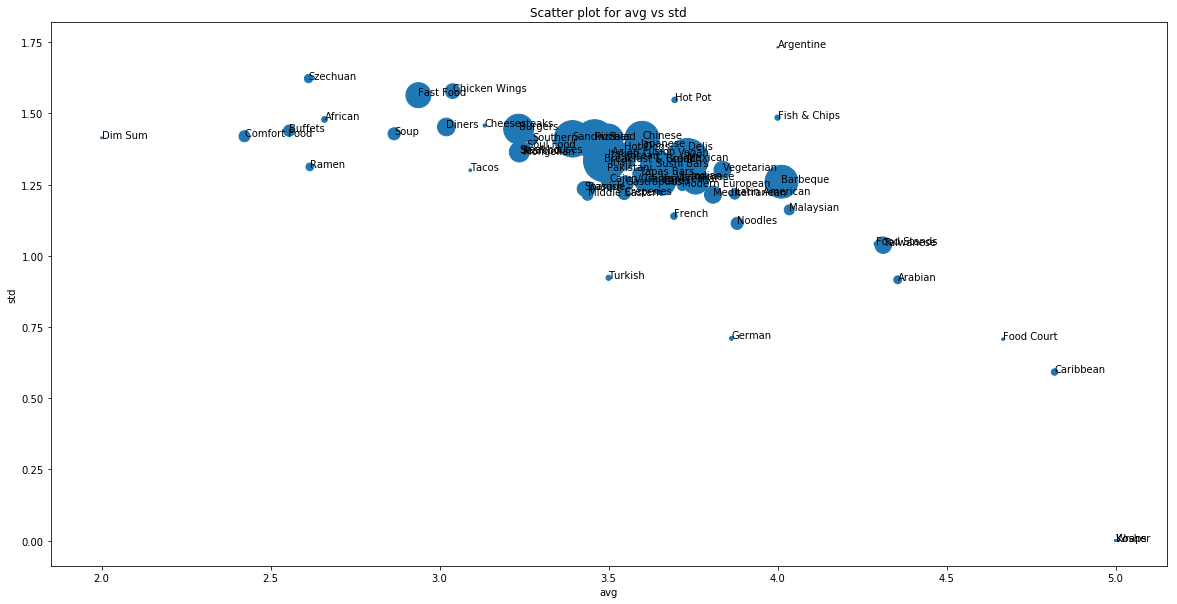

In [6]:
df['count'] = df['count'].apply(lambda value: value * 0.7)

fig, ax = plt.subplots(figsize=((20, 10)))
df.plot.scatter(x='avg', y='std', s=df['count'].values, ax=ax)

for _, row in df.iterrows():
    ax.annotate(row['category'], (row['avg'], row['std']))

ax.set_title('Scatter plot for avg vs std')
    
plt.show()

### Analysis

Since the scatter simply show the relation of rating average and standard deviation, we wish to find the type with higher average rating and lower standard deviation because a higher average rating means the type of restaurant is liked by most people in Champaign, and a lower standard deviation means the review is more stable. The round size demonstrates the number of rating people; the larger the more reliable because more people has reviewed. That kind of type of restaurant will located at the right bottom corner in scatter map and be with larger radius. Thus we could find the Barbeque which is loved by most of the people.

## How does your city compare to other major cities or nearby towns?

We compare the rating of Barbeque restaurant in Champaign with that in nearby towns, and overall level.

In [7]:
df = query("""
select
  business.city, review.stars
from
  business
left join category
 on business.id = category.business_id
left join review
 on business.id = review.business_id
where category.category = "Barbeque"
""")

df.head()

,city,stars
0,Phoenix,1
1,Phoenix,2
2,Phoenix,3
3,Phoenix,3
4,Phoenix,1


In [8]:
champaign = convert_df_to_vector(df[df.city.isin(['Champaign', 'Urbana'])].stars)
nearby = convert_df_to_vector(df[df.city.isin(['Savoy', 'Peoria'])].stars)
overall = convert_df_to_vector(df.stars)

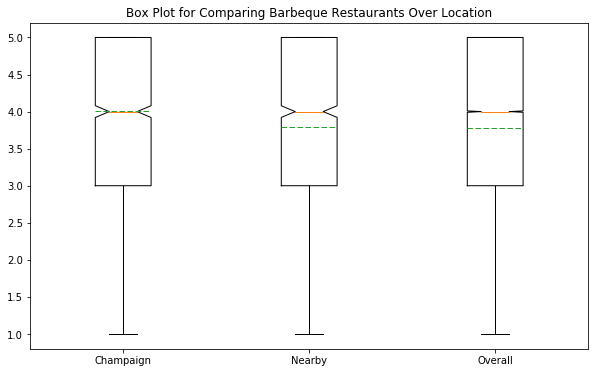

Champaign mean 4.011658031088083
Nearby mean 3.791510611735331
Overall mean 3.7764969991295185


In [12]:
all_data = [champaign, nearby, overall]
labels = ['Champaign', 'Nearby', 'Overall']

fig, ax = plt.subplots(figsize=(10, 6))

ax.boxplot(all_data, labels=labels, showmeans=True, meanline=True, notch=True)

ax.set_xticks([1,2,3])
ax.set_xticklabels(labels)
ax.set_title('Box Plot for Comparing Barbeque Restaurants Over Location')

plt.show()

for label, data in zip(labels, all_data):
    print('{} mean {}'.format(label, np.mean(data)))


### Analysis

We can observe that they have very similar median of rating, but the mean rating of Barbeque restaurant in Champaign is significantly higher than nearby towns as well as overall level, thus the Barbeque restaurant in Champaign is better than other places.

# Part 2 What can be learned from the review text itself?


#### Pull out and preprocess related data. Save the data into three groups (restaruants, coffee and tea, bars) for future use.

In [13]:
# For Box Plot
import matplotlib as mpl 
import matplotlib.pyplot as plt 
## agg backend is used to create plot as a .png file
mpl.use('agg')


# For Data Access
import pandas as pd
import sqlite3 as sql


/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [14]:
# Access the restaurants review texts.

# Change the limit to any number.
# Usually larger number means more accurate results (but also slower run time)
query_review_restaurants = '''select r.text, r.stars, b.city
                            from review as r
                            join category as c
                            on r.business_id = c.business_id
                            join business as b
                            on b.id = r.business_id
                            where c.category in ("Restaurants")
                            and b.city in ("Champaign")
                            limit 1000
                            '''
# Data for the restaurants
with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    data = pd.read_sql(query_review_restaurants, con)

array = data.as_matrix()

reviews_restaurants = [a[0] for a in array]
stars_restaurants = [a[1] for a in array]

In [15]:
# Access the coffee_tea review texts.

# Change the limit to any number.
# Usually larger number means more accurate results (but also slower run time)
query_review_coffee_tea = '''select r.text, r.stars
                            from review as r
                            join category as c
                            on r.business_id = c.business_id
                            join business as b
                            on b.id = r.business_id
                            where c.category in ("Coffee & Tea")
                            and b.city in ("Champaign")
                            limit 1000
                            '''

# Data for the coffee_tea
with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    data = pd.read_sql(query_review_coffee_tea, con)

array = data.as_matrix()

reviews_coffee_tea = [a[0] for a in array]
stars_coffee_tea = [a[1] for a in array]

In [16]:
# Access the bars review texts.

# Change the limit to any number.
# Usually larger number means more accurate results (but also slower run time)
query_review_bars = '''select r.text, r.stars
                            from review as r
                            join category as c
                            on r.business_id = c.business_id
                            join business as b
                            on b.id = r.business_id
                            where c.category in ("Bars")
                            and b.city in ("Champaign")
                            limit 1000
                            '''

# Data for the bars
with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    data = pd.read_sql(query_review_bars, con)

array = data.as_matrix()

reviews_bars = [a[0] for a in array]
stars_bars = [a[1] for a in array]

### Whats the sentiment towards different types of eateries?
--- Restaurants


We analyzed "reviews_restaurants" by using SentimentIntensityAnalyzer.
We use nltk library to do the machine learning by sorting reviews in different star levels. For each review star level, very positive review values 1, and very negative review values -1. After using nltk to evaluating the review positive/negative level, we visualized the results in the box plot. 
###### Nltk library cannot do the visulization right below the code so we save the box plots in the same file outside this notebook.

In [17]:
# Whats the sentiment towards different types of eateries?

# Part 1: Restaurants
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
compounds_1 = []
compounds_2 = []
compounds_3 = []
compounds_4 = []
compounds_5 = []
i = 0
for sentence in reviews_restaurants:
    ss = sid.polarity_scores(sentence)
    compound = ss['compound']
    if stars_restaurants[i] == str(1):
        compounds_1 += [compound]
    elif stars_restaurants[i] == str(2):
        compounds_2 += [compound]
    elif stars_restaurants[i] == str(3):
        compounds_3 += [compound]
    elif stars_restaurants[i] == str(4):
        compounds_4 += [compound]
    elif stars_restaurants[i] == str(5):
        compounds_5 += [compound]
    i += 1


## combine these different collections into a list 
data_to_plot = [compounds_1,compounds_2,compounds_3,compounds_4,compounds_5]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)


# Save the figure
fig.savefig('restaurants_box_plot_for_compound_vs_stars.png', bbox_inches='tight')


--- Coffee & Tea


We analyzed "reviews_coffee_tea" by using SentimentIntensityAnalyzer. We use nltk library to do the machine learning by sorting reviews in different star levels. For each review star level, very positive review values 1, and very negative review values -1. After using nltk to evaluating the review positive/negative level, we visualized the results in the box plot. 
##### Nltk library cannot do the visulization right below the code so we save the box plot in the same file outside this notebook.

In [18]:
# Whats the sentiment towards different types of eateries?

# Part 2: Coffee & Tea
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
compounds_1 = []
compounds_2 = []
compounds_3 = []
compounds_4 = []
compounds_5 = []
i = 0
for sentence in reviews_coffee_tea:
    ss = sid.polarity_scores(sentence)
    compound = ss['compound']
    if stars_coffee_tea[i] == str(1):
        compounds_1 += [compound]
    elif stars_coffee_tea[i] == str(2):
        compounds_2 += [compound]
    elif stars_coffee_tea[i] == str(3):
        compounds_3 += [compound]
    elif stars_coffee_tea[i] == str(4):
        compounds_4 += [compound]
    elif stars_coffee_tea[i] == str(5):
        compounds_5 += [compound]
    i += 1


## combine these different collections into a list 
data_to_plot = [compounds_1,compounds_2,compounds_3,compounds_4,compounds_5]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)


# Save the figure
fig.savefig('coffee_tea_box_plot_for_compound_vs_stars.png', bbox_inches='tight')


--- Bars


We analyzed "reviews_bars" by using SentimentIntensityAnalyzer. We use nltk library to do the machine learning by sorting reviews in different star levels. For each review star level, very positive review values 1, and very negative review values -1. After using nltk to evaluating the review positive/negative level, we visualized the results in the box plot. 
##### Nltk library cannot do the visulization right below the code so we save the box plot in the same file outside this notebook. 

In [19]:
# Whats the sentiment towards different types of eateries?

# Part 3: Bars
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
compounds_1 = []
compounds_2 = []
compounds_3 = []
compounds_4 = []
compounds_5 = []
i = 0
for sentence in reviews_bars:
    ss = sid.polarity_scores(sentence)
    compound = ss['compound']
    if stars_bars[i] == str(1):
        compounds_1 += [compound]
    elif stars_bars[i] == str(2):
        compounds_2 += [compound]
    elif stars_bars[i] == str(3):
        compounds_3 += [compound]
    elif stars_bars[i] == str(4):
        compounds_4 += [compound]
    elif stars_bars[i] == str(5):
        compounds_5 += [compound]
    i += 1


## combine these different collections into a list 
data_to_plot = [compounds_1,compounds_2,compounds_3,compounds_4,compounds_5]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)


# Save the figure
fig.savefig('bars_box_plot_for_compound_vs_stars.png', bbox_inches='tight')


In [20]:
# For topic modeling

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 6

# Function to compute top topic terms from given model (i.e., LDA or NMF)

def get_topics(cv, model):
    # Number of terms per topic to display
    max_topics = 10

    # Number of terms per topic to retain
    max_labels = 5

    topics = []
    feature_names = cv.get_feature_names()

    # Iterate through the matrix components
    for idx, topic in enumerate(model.components_):

        # First we sort the terms in descending order ([::-1])
        # And then retiain only the top terms
        top_topics_idx = topic.argsort()[::-1][:max_topics]

        top_topics = [feature_names[jdx] for jdx in top_topics_idx]

        # Now extract out the terms themselves and display
        top_features = " ".join(top_topics)
        print('Topic {0:2d}: {1}'.format(idx, top_features))
        topics.append(", ".join(top_topics[:max_labels]))
        
    return(topics)


# We display a wrod cloud

import numpy as np

from wordcloud import WordCloud

def make_wc(text, title=''):

    wc = WordCloud(background_color="white", max_words=1000)

    # generate word cloud
    wc.generate(text)

    plt.imshow(wc)
    plt.axis("off")
    plt.title(title, fontsize=24)
    plt.show()

From the box plots, we can tell the the more stars the customer gives, the more positive the review content shows. The less stars the customer gives, the larger range of the review content shows. For example, for one star restaurant, the positive level of review content almost ranges from +1 to -1 while for five star restaurant, the positivie level basically ranges from +0.5 to +1.

### What are reviewers talking about the most?
--- Restaurants


We use lda to sort the keywords into 6 topics and calculate the appearance frequency of each word. The larger the word is, the more times it appearred in the review texts.We also generate a overall graph to show illustrate the frequency of every word in every topic in one place.

Topic  0: shake machine harder garbage smh gloves bags mcdonalds bag excessive
Topic  1: health public code rules coca cola failed general jillian food
Topic  2: food good place great service like time just really ve
Topic  3: luna advice clear location good attempted employee food smh brunch
Topic  4: shampoo banana hole thai wall balancing great amazing margaritas place
Topic  5: bloomington november 2011 great food luna wait sausage mall ones


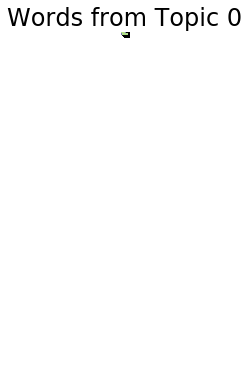

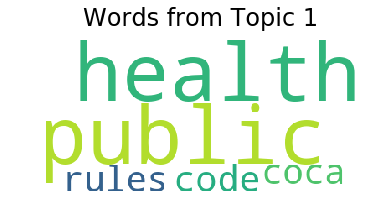

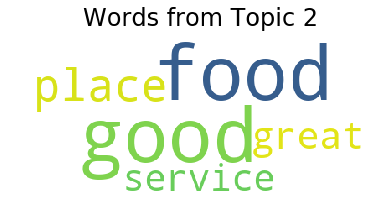

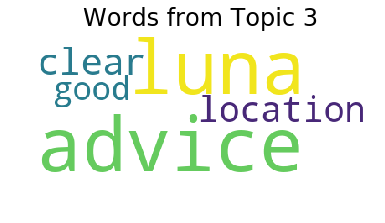

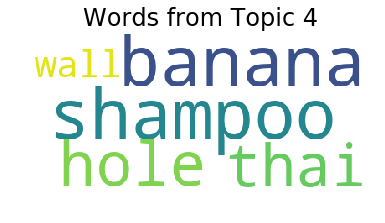

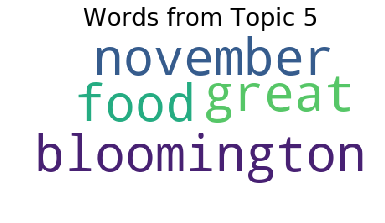

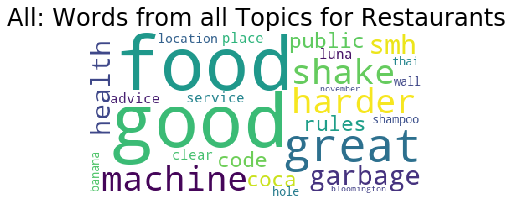

In [21]:
# What are reviewers talking about the most?
# Part 1: Restaurants
cv = TfidfVectorizer(stop_words = 'english',
                     lowercase=True,
                     min_df=2,
                     max_features=5000)


restaurants_reviews_data = cv.fit_transform(reviews_restaurants)

lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5,
                                learning_method='online', learning_offset=5.,
                                random_state=23).fit(restaurants_reviews_data)

lda_topics = get_topics(cv, lda)
    
for i in range(len(lda_topics)):
    make_wc(lda_topics[i].replace(',', ''), 'Words from Topic ' + str(i))

# Will be used to visualize all types
all_text = []

text = ', '.join(lda_topics)
all_text += [text]
make_wc(text.replace(',', ''), 'All: Words from all Topics for Restaurants')

Topic  0: nalways customize scones raspberry almond welcome connection class windsor duncan
Topic  1: leche daughter il leaf champagne coffee confections service spectacular chicago
Topic  2: exception missed boat holiday rule venti fat milk extra great
Topic  3: coffee place tea good great really cupcakes ice like love
Topic  4: coffee good food place ve starbucks great just like service
Topic  5: coffee people work thank mint wait drink able place bulk


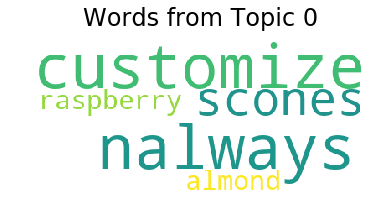

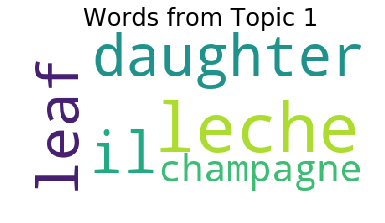

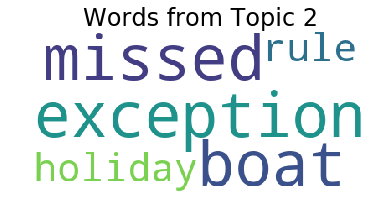

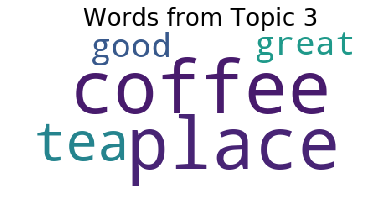

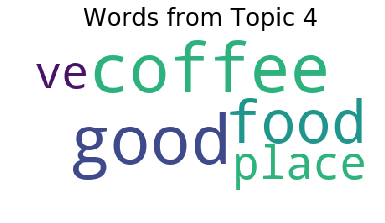

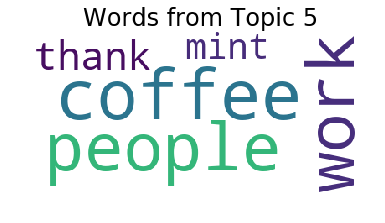

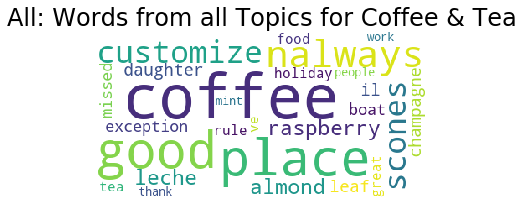

In [22]:

# What are reviewers talking about the most?
# Part 2: Coffee_tea
cv = TfidfVectorizer(stop_words = 'english',
                     lowercase=True,
                     min_df=2,
                     max_features=5000)

coffee_tea_reviews_data = cv.fit_transform(reviews_coffee_tea)

lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5,
                                learning_method='online', learning_offset=5.,
                                random_state=23).fit(coffee_tea_reviews_data)

lda_topics = get_topics(cv, lda)

for i in range(len(lda_topics)):
    make_wc(lda_topics[i].replace(',', ''), 'Words from Topic ' + str(i))

text = ', '.join(lda_topics)
all_text += [text]
make_wc(text.replace(',', ''), 'All: Words from all Topics for Coffee & Tea')

Topic  0: tradition smells goes bud darts cly campus place nquality floor
Topic  1: june service write menu review coffee county necessary long excellent
Topic  2: harder imo loss franchise national chevy skillet microwaved enchilada trash
Topic  3: nbad shut justify rent keeping underage hop firehaus slippery snobby
Topic  4: food place good great service bar like just really time
Topic  5: thai good bar scotty friendly place selection food craft recommend


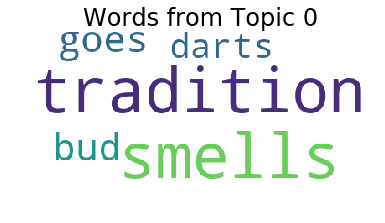

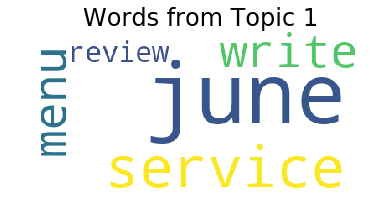

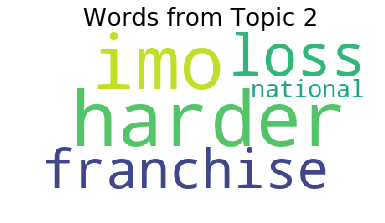

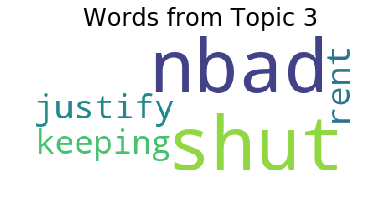

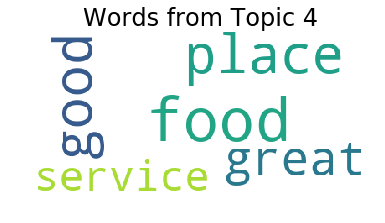

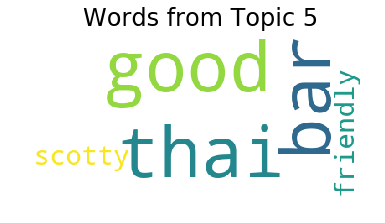

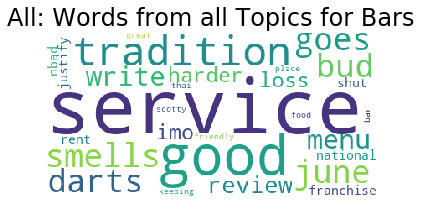

In [23]:
# What are reviewers talking about the most?
# Part 3: Bars
cv = TfidfVectorizer(stop_words = 'english',
                     lowercase=True,
                     min_df=2,
                     max_features=5000)

bars_reviews_data = cv.fit_transform(reviews_bars)

lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5,
                                learning_method='online', learning_offset=5.,
                                random_state=23).fit(bars_reviews_data)

lda_topics = get_topics(cv, lda)

for i in range(len(lda_topics)):
    make_wc(lda_topics[i].replace(',', ''), 'Words from Topic ' + str(i))
    
text = ', '.join(lda_topics)
all_text += [text]
make_wc(text.replace(',', ''), 'All: Words from all Topics for Bars')

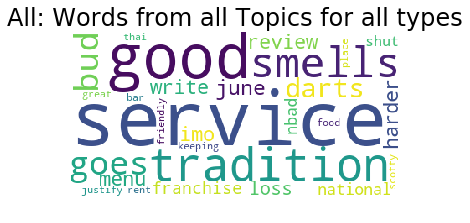

In [24]:
# For all types:
text = ', '.join(lda_topics)
make_wc(text.replace(',', ''), 'All: Words from all Topics for all types')

# Part 3  Bussiness Pattern and User Preference

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import pymc3 as pm
import sqlite3 as sql

query = '''select b.*,
                  c.category,
                  r.*
           from business as b
           left join category as c
             on b.id = c.business_id
           left join review as r
             on b.id = r.business_id
           where b.city in ("Champaign", "Urbana")
           '''

query2 = '''select 
            r.user_id,
            b.name,
            f.friend_id
            from review as r
            left join business as b
                on r.business_id = b.id
            left join category as c
                on r.business_id = c.business_id
            left join friend as f
                 on r.user_id = f.user_id    
           where b.city in ("Champaign") and c.category ="Restaurants"
           '''
query3 = '''select 
            r.user_id,
            b.name,
            f.friend_id
            from review as r
            left join business as b
                on r.business_id = b.id
            left join category as c
                on r.business_id = c.business_id
            left join friend as f
                 on r.user_id = f.user_id    
           where b.city in ("Urbana") and c.category ="Restaurants"
           '''


with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    data = pd.read_sql(query,con)
    friend_id_C= pd.read_sql(query2,con)
    friend_id_U = pd.read_sql(query3,con)

In [26]:
df = data[['name','city','category', 'stars','user_id']]
df.columns =['name','city','category', 'store_stars','user_rate','user_id']
dfa = df.loc[df['category'] == 'Restaurants']
dfb = dfa[['store_stars','user_rate']].astype('float')
dfb.describe()

,store_stars,user_rate
count,20957.000000,20957.000000
mean,3.613852,3.592069
std,0.613320,1.357742
min,1.000000,1.000000
25%,3.000000,3.000000
50%,3.500000,4.000000
75%,4.000000,5.000000
max,5.000000,5.000000


In [27]:
dfa.describe()

,name,city,category,store_stars,user_rate,user_id
count,20957,20957,20957,20957,20957,20957
unique,417,2,1,9,5,7827
top,Black Dog Smoke & Ale House,Champaign,Restaurants,4,5,qntQp9UoeP6ju8D_W0Y0cw
freq,883,16279,20957,6423,6961,107


In [28]:
dfa['name'].value_counts().nlargest(10)

Black Dog Smoke & Ale House                883
Maize Mexican Grill                        448
DESTIHL Restaurant & Brew Works            448
Papa Del's Pizza                           352
Golden Harbor Authentic Chinese Cuisine    337
Courier Cafe                               304
Radio Maria                                287
Sakanaya Restaurant                        282
Kofusion                                   277
Seven Saints                               273
Name: name, dtype: int64

## Information Found on Preprocessing Data

From the above we found these information to be useful. First of all in Urbana-Champaign area there are 417 retaurant on yelp that gets rated. There are about 7827 users that rates the restaurant. Among all these restaurant Black Dog Smoke & Ale House gets most reviews, indicating this one is a very popular restaurant in the area.

## Quesiton 3: Do users who visit one business tend to visit certain other businesses?

For this question, we want to find out that if a user visiting one certain business, which restuarant will he be more likely to visit. Since we have this data set, we could find out that a Yelp user who rated certain resturant also rated another restaurant. We will also draw the co-occurance graph to demostrate this point.Please note that even  business has one or two restuarant we still treat it as one business. That is why we take he name as a input in this part of analysis. Even a business has two restuarant in the different location, we still treat it as a business and what we are trying to find is that if there is a certain business or business model that is very successful and users prefer it in common. Also we are tryiing to see if different users has same common thing within its friend groups. 

In [30]:
dfa['user_rate']=dfb['user_rate']
dfa['store_stars']=dfb['store_stars']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
stats = dfa.groupby('name').agg({'user_rate': [np.size, np.mean]})
rating_count = 100
top_restuarant = stats['user_rate']['size']>=rating_count
stats[top_restuarant].sort_values(by=('user_rate','mean'), ascending = False).head(10)

user_rate          
                                             size      mean
name                                                       
Maize Mexican Grill                         448.0  4.444196
Huaraches Moroleon                          146.0  4.410959
Golden Harbor Authentic Chinese Cuisine     337.0  4.362018
Black Dog Smoke & Ale House                 883.0  4.345413
Sakanaya Restaurant                         282.0  4.312057
Aroma Cafe                                  120.0  4.208333
Original Pancake House                      170.0  4.141176
Thara Thai                                  166.0  4.138554
Farren's Pub & Eatery                       225.0  4.120000
Bangkok Thai and Pho 911                    146.0  4.082192

In [32]:
from collections import Counter
from itertools import combinations
tkns = set()
cnt = Counter()
a = []
i = 0
dfd = dfa[['user_id','name']]
dfe = dfd.sort_values('user_id')
datas= dfe.groupby(['user_id'])['name'].apply(list).to_dict()
datas_list = list(datas.values())
for datas in datas_list:
    datas = sorted(datas)
    for data in datas:
        tkns.add(data)
    for paired_datas in combinations(sorted(list(set(datas))), 2):
        cnt[paired_datas]+=1

In [33]:
top_tkns = set()
num_top_pairs =20
top_pairs = cnt.most_common(num_top_pairs)
for pair, count in top_pairs:
    top_tkns.add(pair[0])
    top_tkns.add(pair[1])
cnt.most_common(20)

[(('Black Dog Smoke & Ale House', 'Maize Mexican Grill'), 131),
 (('Black Dog Smoke & Ale House', 'DESTIHL Restaurant & Brew Works'), 121),
 (('Black Dog Smoke & Ale House', 'Courier Cafe'), 95),
 (('Black Dog Smoke & Ale House', 'Golden Harbor Authentic Chinese Cuisine'),
  85),
 (('Black Dog Smoke & Ale House', 'Seven Saints'), 79),
 (('Black Dog Smoke & Ale House', "Papa Del's Pizza"), 76),
 (('Black Dog Smoke & Ale House', "Farren's Pub & Eatery"), 74),
 (('DESTIHL Restaurant & Brew Works', 'Seven Saints'), 72),
 (('Black Dog Smoke & Ale House', 'Crane Alley'), 70),
 (('DESTIHL Restaurant & Brew Works', 'Maize Mexican Grill'), 69),
 (('Big Grove Tavern', 'Black Dog Smoke & Ale House'), 68),
 (('Big Grove Tavern', 'DESTIHL Restaurant & Brew Works'), 67),
 (('Black Dog Smoke & Ale House', 'Sakanaya Restaurant'), 64),
 (('Black Dog Smoke & Ale House', 'Kofusion'), 62),
 (('Black Dog Smoke & Ale House', 'Radio Maria'), 60),
 (('Black Dog Smoke & Ale House', 'Original Pancake House'), 5

## Information found after analyzing the data:

From here we have found that user rated 'black dog smoke & ale house' is likely to rate Maize Mexican Grill the same time. That means the user visits Black Dog Smoke & Ale House is likely to visit Maize Mexican Grill. The 20 restuarant that has been visited simutaniously is:

- 'Black Dog Smoke & Ale House', 'Maize Mexican Grill'
- 'Black Dog Smoke & Ale House', 'DESTIHL Restaurant & Brew Works'
- 'Black Dog Smoke & Ale House', 'Courier Cafe'
- 'Black Dog Smoke & Ale House', 'Seven Saints'
- 'Black Dog Smoke & Ale House', "Papa Del's Pizza"
- 'Black Dog Smoke & Ale House', "Farren's Pub & Eatery"
- 'DESTIHL Restaurant & Brew Works', 'Seven Saints'
- 'Black Dog Smoke & Ale House', 'Crane Alley'
- 'DESTIHL Restaurant & Brew Works', 'Maize Mexican Grill'
- 'Big Grove Tavern', 'Black Dog Smoke & Ale House'
- 'Big Grove Tavern', 'DESTIHL Restaurant & Brew Works'
- 'Black Dog Smoke & Ale House', 'Sakanaya Restaurant'
- 'Black Dog Smoke & Ale House', 'Kofusion'- 
- 'Black Dog Smoke & Ale House', 'Radio Maria'
- 'Black Dog Smoke & Ale House', 'Original Pancake House'
- 'Golden Harbor Authentic Chinese Cuisine', 'Maize Mexican Grill'
- 'DESTIHL Restaurant & Brew Works', 'Radio Maria'
- 'Big Grove Tavern', 'Maize Mexican Grill'
- 'Courier Cafe', 'Maize Mexican Grill'
- 'Courier Cafe', 'DESTIHL Restaurant & Brew Works'
From this list we could see that there are a lot of Black Dog Smoke & Ale House, this does not surprise me since that this restaurant is most rated restaurant in the area. From previous information we have found that the Black Dog Smoke & Ale House has been rated 883 times. So that if a user went to black dog smoke & Ale House, he or she is very likely to go to Maize Mexican Grill, Destihl restuarant & Brew Works, Courier Cafe and Seven Saints according the result generated. From here we can also see that a user even if he or she went to other type of business, he or she is also likely to go to the Black Dog Smoke & Ale House. 

### Visualize the Data¶

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


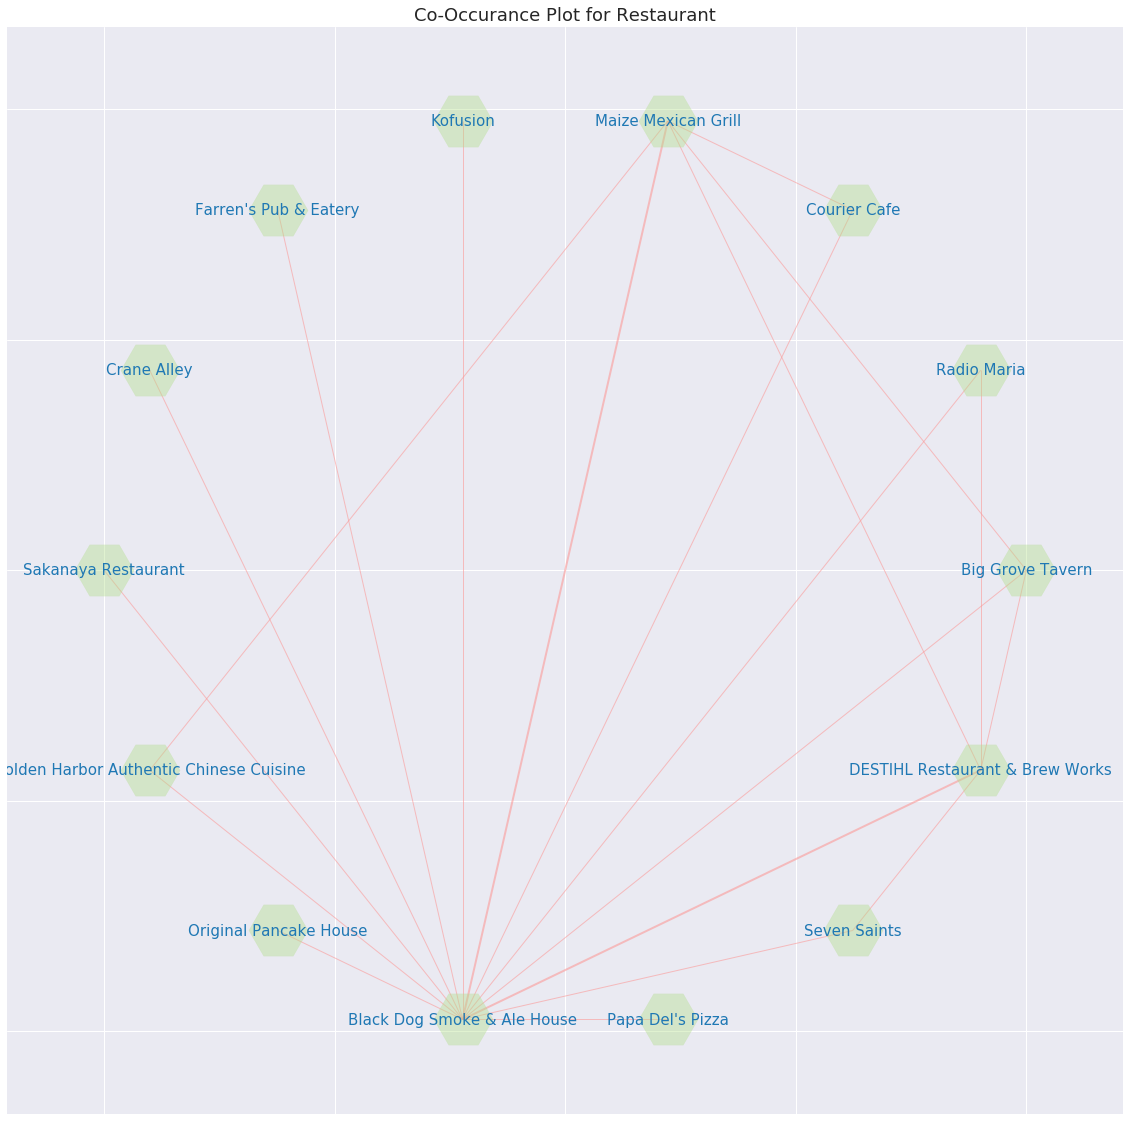

In [34]:
import seaborn as sns
fig, axs = plt.subplots(figsize=(20,20))

clrs = sns.color_palette("Paired")

sns.set(style='white', font_scale=1.5)

import networkx as nx
g = nx.Graph()
g.add_nodes_from(list(top_tkns))
for pair, count in top_pairs:
    g.add_edge(pair[0], pair[1], weight=count)

pos = nx.circular_layout(g)

nx.draw_networkx_nodes(g, pos, with_labels=True,
                       node_size = 3500,
                       node_color=clrs[2],
                       node_shape='H',
                       alpha = 0.4)
edges = []
weights = []
for n1, n2, dct in g.edges(data=True):
    edges.append((n1, n2))
    weights.append(dct['weight'])

min_weight = min(weights)
norm_weights = [int(weight/min_weight) for weight in weights]


nx.draw_networkx_edges(g, pos, edgelist=edges, 
                       width = norm_weights, 
                       edge_color=clrs.as_hex()[4],
                       alpha = 0.6)


nx.draw_networkx_labels(g, pos, font_size = 15,
                        font_color = clrs[1],
                        alpha = 1.0)
axs.set_title('Co-Occurance Plot for Restaurant')
axs.set_xticklabels([])
axs.set_yticklabels([])

sns.despine(top = True, bottom = True, 
            left = True, right = True)

#### This is the graph showing the co-occurance plot for top 20 paired restaurant in Urbaba-Champaign area.
From the information found in the graph and the list we made we could see that the Black Dog Smoke and Ale House has a really suceesful business model that we could study. This business model is so successful that even a user who likes Pizza, Chinese food or other kind of restaurant in the area, he or she likes to visit Black Dog Smoke and Ale House. 

### What if I have a user_ID and I want to find out if his or her friends tend to visit certain business together?

As questions stated, going two buesinss together means he or she rated two restaurant in the yelp. In order to answer this question, we could write a function that takes in a user_id and output his or her friends' certain pattern on choosing the restaurant. We will take these user_IDs as examples to generate output as these user_IDs have the most friends attached to them.

Write Function that takes in a user_id and output the most commonly visited restaurant among friends

In [35]:
mydict = dfe.groupby(['user_id'])['name'].apply(list).to_dict()
fi_U= friend_id_U[['user_id', 'friend_id']]
fi_C = friend_id_C[['user_id', 'friend_id']]
frames = [fi_U,fi_C]
friend_list = pd.concat(frames)
friend_dict = friend_list.groupby(['user_id'])['friend_id'].apply(list).to_dict()

In [36]:
new_store_list = []
def pair(keys,number_of_pairs):
    new_list = friend_dict.get(keys)
    a_list = [mydict.get(k)for k in new_list]
    for item in a_list:
        if item != None:
            new_store_list.append(item)
    tokens = set()
    counts = Counter()
    for values in new_store_list:
        values = sorted(values)
    for value in values:
        tokens.add(value)
    for paired_datas in combinations(sorted(list(set(values))), 2):
        counts[paired_datas]+=1
    
    top_pair = counts.most_common(number_of_pairs)
        
    
    return top_pair

In [37]:
def friend_figure(keys,number_of_pairs):
    new_list = friend_dict.get(keys)
    a_list = [mydict.get(k)for k in new_list]
    for item in a_list:
        if item != None:
            new_store_list.append(item)
    tokens = set()
    counts = Counter()
    for values in new_store_list:
        values = sorted(values)
    for value in values:
        tokens.add(value)
    for paired_datas in combinations(sorted(list(set(values))), 2):
        counts[paired_datas]+=1
    
    friend_pair = counts.most_common(number_of_pairs)
    top_tokens = set()
    top = friend_pair
    for pair, count in top:
        top_tokens.add(pair[0])
        top_tokens.add(pair[1])


    fig, axs = plt.subplots(figsize=(10,10))

    clrs = sns.color_palette("Paired")

    sns.set(style='white', font_scale=1.5)


    g = nx.Graph()
    g.add_nodes_from(list(top_tokens))
    for pair, count in top:
        g.add_edge(pair[0], pair[1], weight=count)

    pos = nx.circular_layout(g)

    nx.draw_networkx_nodes(g, pos, with_labels=True,
                           node_size = 1000,
                           node_color=clrs[2],
                           node_shape='H',
                           alpha = 0.4)
    edges = []
    weights = []
    for n1, n2, dct in g.edges(data=True):
        edges.append((n1, n2))
        weights.append(dct['weight'])

    min_weight = min(weights)
    norm_weights = [int(weight/min_weight) for weight in weights]


    nx.draw_networkx_edges(g, pos, edgelist=edges, 
                           width = norm_weights, 
                           edge_color=clrs.as_hex()[4],
                           alpha = 0.6)


    nx.draw_networkx_labels(g, pos, font_size = 10,
                            font_color = clrs[1],
                            alpha = 1.0)
    axs.set_title('Co-Occurance Plot for friends in user_id '+ str(keys))
    axs.set_xticklabels([])
    axs.set_yticklabels([])

    sns.despine(top = True, bottom = True, 
                left = True, right = True)
    return axs

### Test Our Code with the Top 3 Users who rated most of the restaurant

So now we have our functions ready, all we need to do is selecting user_id from our data frame to test see if this user's friend has a preference in choosing the restaurant.

In [38]:
dfa['user_id'].value_counts().nlargest(3)

qntQp9UoeP6ju8D_W0Y0cw    107
B8WruADju0mx5FlkLfYYfw    104
qmjoMFMZdLH69_6eGTGDZw    101
Name: user_id, dtype: int64

In [39]:
pair('qntQp9UoeP6ju8D_W0Y0cw',10)

[(('Black Dog Smoke & Ale House', 'Courier Cafe'), 1),
 (('Black Dog Smoke & Ale House', 'Crane Alley'), 1),
 (('Black Dog Smoke & Ale House', 'DESTIHL Restaurant & Brew Works'), 1),
 (('Black Dog Smoke & Ale House', 'Golden Harbor Authentic Chinese Cuisine'),
  1),
 (('Black Dog Smoke & Ale House', "Minneci's at the Crossing"), 1),
 (('Black Dog Smoke & Ale House', 'My Thai'), 1),
 (('Black Dog Smoke & Ale House', 'Original Pancake House'), 1),
 (('Black Dog Smoke & Ale House', 'Pekara Bakery and Bistro'), 1),
 (('Black Dog Smoke & Ale House', 'Pizza M'), 1),
 (('Black Dog Smoke & Ale House', 'Sakanaya Restaurant'), 1)]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


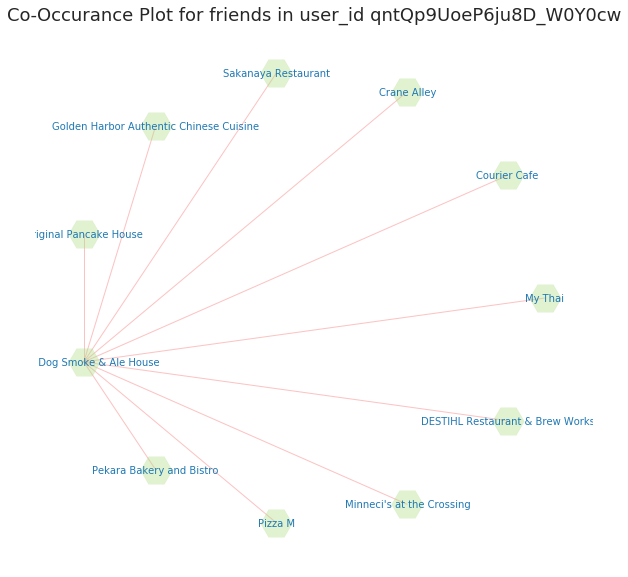

In [40]:
friend_figure('qntQp9UoeP6ju8D_W0Y0cw' ,10)

[(('Evo Cafe', 'Koto Ramen'), 1)]


[(('Evo Cafe', 'Koto Ramen'), 1)]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


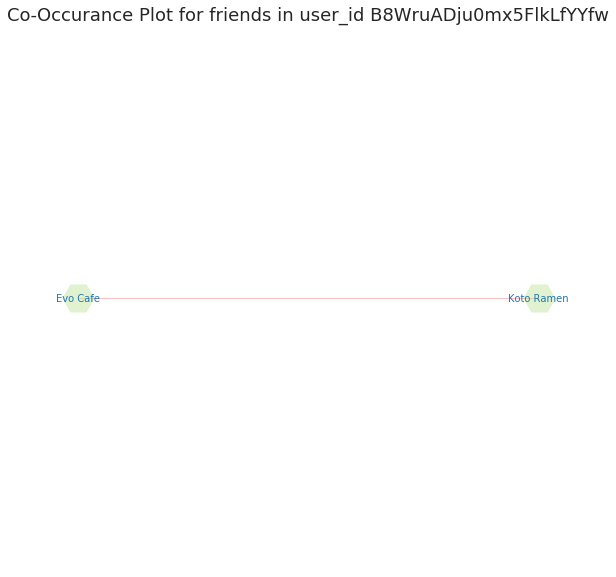

In [41]:
print (pair('B8WruADju0mx5FlkLfYYfw',10))
friend_figure('B8WruADju0mx5FlkLfYYfw',10)
[(('Evo Cafe', 'Koto Ramen'), 1)]

In [42]:
pair('qmjoMFMZdLH69_6eGTGDZw',10)

[(('A-Ri-Rang', 'First Wok'), 1),
 (('A-Ri-Rang', 'Golden Harbor Authentic Chinese Cuisine'), 1),
 (('A-Ri-Rang', 'Green Jade'), 1),
 (('A-Ri-Rang', "Lil Porgy's Bar-B-Que"), 1),
 (('A-Ri-Rang', 'Mandarin Wok'), 1),
 (('A-Ri-Rang', 'Pekara Bakery and Bistro'), 1),
 (('A-Ri-Rang', 'Woori Jib Restaurant'), 1),
 (('First Wok', 'Golden Harbor Authentic Chinese Cuisine'), 1),
 (('First Wok', 'Green Jade'), 1),
 (('First Wok', "Lil Porgy's Bar-B-Que"), 1)]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


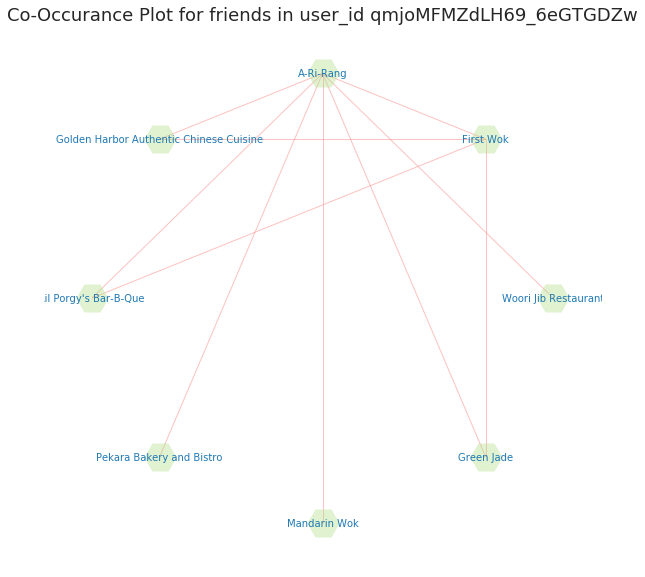

In [43]:
friend_figure('qmjoMFMZdLH69_6eGTGDZw',10)

### More Test on Using user_id with Most Friends in the Data

In [44]:
sorted_keylist = []
for key in sorted(friend_dict, key = lambda key:len(friend_dict.get(key)),reverse = True):
    sorted_keylist.append(key)
pair(sorted_keylist[0],10)

[(("J Gumbo's", "Let's Take a Seat: Thai Cuisine"), 1),
 (("J Gumbo's", 'Meatheads'), 1),
 (("Let's Take a Seat: Thai Cuisine", 'Meatheads'), 1)]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


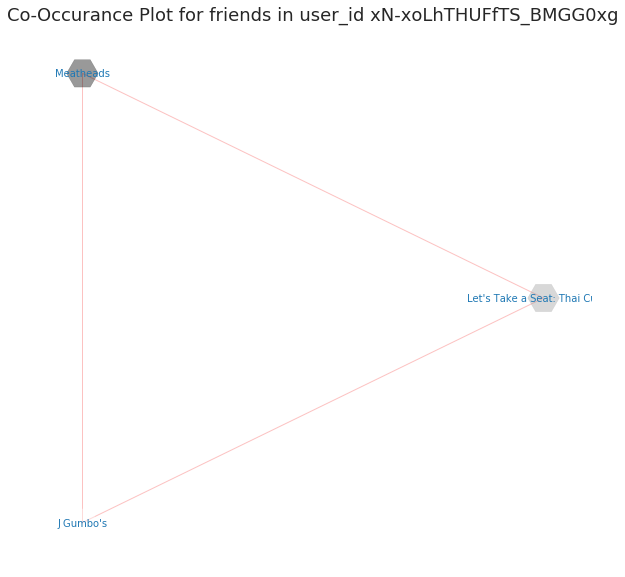

In [45]:
friend_figure(sorted_keylist[0],10)

In [46]:
pair(sorted_keylist[1],10)

[]

In [47]:
pair(sorted_keylist[2],10)

[]

In [48]:
pair(sorted_keylist[3],10)

[(('Black Dog Smoke & Ale House', 'Courier Cafe'), 1),
 (('Black Dog Smoke & Ale House', 'Crane Alley'), 1),
 (('Black Dog Smoke & Ale House', 'DESTIHL Restaurant & Brew Works'), 1),
 (('Black Dog Smoke & Ale House', 'Golden Harbor Authentic Chinese Cuisine'),
  1),
 (('Black Dog Smoke & Ale House', "Minneci's at the Crossing"), 1),
 (('Black Dog Smoke & Ale House', 'My Thai'), 1),
 (('Black Dog Smoke & Ale House', 'Original Pancake House'), 1),
 (('Black Dog Smoke & Ale House', 'Pekara Bakery and Bistro'), 1),
 (('Black Dog Smoke & Ale House', 'Pizza M'), 1),
 (('Black Dog Smoke & Ale House', 'Sakanaya Restaurant'), 1)]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


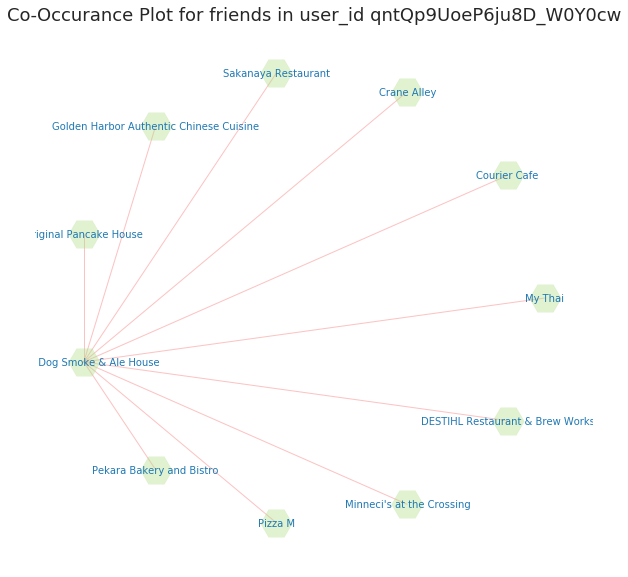

In [49]:
friend_figure(sorted_keylist[3],10)

## Conclusion on Friends' Preference Data Questions:

By using this function, we have runned the function and selected some of representative sample to analyze this question. We have found that it is sometimes really hard to find what two business a user's friend have visited in the same time. There are multiple reasons behind this becasue sometimes a person's friend may not be very active on yelp even if he or she is the friend of our sampling user. Or when our sampling user have friend from other different places and have eating habits.

However, we do find that some users might have group of friends that likes to visit the same restaurant if his or her friend is very active in the internet. For example, we could see that User "qmjoMFMZdLH69_6eGTGDZw" has a group of friends that seems going to "A-Ri-Rang" a lot. And user "'qntQp9UoeP6ju8D_W0Y0cw' and user "nkN_do3fJ9xekchVC-v68A" has a group of friends that voted Black Dog Smoke & Ale House so that there is a chance they visit that place a lot. 
To conclude, we did not find that different users' group would have similarities in its friend group but we do find there might be a chance that each individual users would have the same preference within its friend group. But there are not much information relative to our investment decisions here. 

# Part 4 Location

In [75]:
! pip install gmplot

In [76]:
query = '''select b.postal_code, b.city,
                  (count(r.stars) * 100.0 / co) percent_top_in_postal_code
           from business as b
           left join category as c
             on b.id = c.business_id
           left join review as r
             on b.id = r.business_id
           inner JOIN (select b.city,
                  count(*) co
           from business as b
           left join category as c
             on b.id = c.business_id
           left join review as r
             on b.id = r.business_id
           where (r.stars=4 or r.stars=5)
           and b.city in ("Urbana", "Champaign")
           and category='Restaurants' group by city) c
            on c.city = b.city
           where (r.stars=4 or r.stars=5)
           and b.city in ("Urbana", "Champaign")
           and category='Restaurants' group by postal_code,b.city order by b.city desc, percent_top_in_postal_code desc'''
with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    data = pd.read_sql(query, con)

pd.set_option('display.max_columns', data.shape[1])

In [77]:
data

,postal_code,city,percent_top_in_postal_code
0,61801,Urbana,81.451350
1,61802,Urbana,17.116824
2,61803,Urbana,1.171494
3,60686,Urbana,0.260332
4,61820,Champaign,80.899455
5,61821,Champaign,10.476485
6,61822,Champaign,7.811053
7,61801,Champaign,0.514562
8,,Champaign,0.298446


We can see a clear clustering of top restaurants rated 4 and 5 stars in just two areas in the cities of Urbana and Champaign. Thus we can infer that these places hold special significance and contribute to higher ratings, or the best restaurants are centered in just one or two locations.

In [78]:
query = '''select b.*,
                  c.category
           from business as b
           left join category as c
             on b.id = c.business_id
           where b.city in ("Champaign", "Urbana")
           '''

with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    data = pd.read_sql(query, con)
pd.set_option('display.max_columns',data.shape[1])

In [79]:
data

,id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category
0,-1TUzO4XCmOeqi9eAGeDWA,Beaumont Tire & Auto Repair,,1202 W Bloomington Rd,Champaign,IL,61821,40.136,-88.2661,4.5,16,1,Auto Repair
1,-1TUzO4XCmOeqi9eAGeDWA,Beaumont Tire & Auto Repair,,1202 W Bloomington Rd,Champaign,IL,61821,40.136,-88.2661,4.5,16,1,Tires
2,-1TUzO4XCmOeqi9eAGeDWA,Beaumont Tire & Auto Repair,,1202 W Bloomington Rd,Champaign,IL,61821,40.136,-88.2661,4.5,16,1,Automotive
3,-2q4dnUw0gGJniGW2aPamQ,Fiesta Ranchera,,1805 S Neil St,Champaign,IL,61820,40.0941,-88.2458,2,4,0,Restaurants
4,-2q4dnUw0gGJniGW2aPamQ,Fiesta Ranchera,,1805 S Neil St,Champaign,IL,61820,40.0941,-88.2458,2,4,0,Mexican
5,-5dd-RjojGVK9hjAMCXVZw,La Fiesta Mexican Restaurant,,1717 Philo Rd,Urbana,IL,61802,40.0965,-88.192,3,13,0,Restaurants
6,-5dd-RjojGVK9hjAMCXVZw,La Fiesta Mexican Restaurant,,1717 Philo Rd,Urbana,IL,61802,40.0965,-88.192,3,13,0,Mexican
7,-5NXoZeGBdx3Bdk70tuyCw,Po' Boys Restaurant,,"202 E University Ave, Ste C",Urbana,IL,61801,40.1177,-88.2059,4,54,1,Restaurants
8,-5NXoZeGBdx3Bdk70tuyCw,Po' Boys Restaurant,,"202 E University Ave, Ste C",Urbana,IL,61801,40.1177,-88.2059,4,54,1,Pizza
9,-5NXoZeGBdx3Bdk70tuyCw,Po' Boys Restaurant,,"202 E University Ave, Ste C",Urbana,IL,61801,40.1177,-88.2059,4,54,1,Barbeque


In [80]:
data[['stars']] = data[['stars']].apply(pd.to_numeric)
data[['latitude']] = data[['latitude']].apply(pd.to_numeric)
data[['longitude']] = data[['longitude']].apply(pd.to_numeric)
df_stars=data.groupby(['latitude', 'longitude'],as_index=False)['stars'].mean()

In [81]:
df_stars

,latitude,longitude,stars
0,40.0262,-88.2991,2.500000
1,40.0363,-88.2640,1.000000
2,40.0634,-88.2950,3.500000
3,40.0693,-88.2921,2.500000
4,40.0759,-88.3230,2.500000
5,40.0809,-88.2963,4.500000
6,40.0809,-88.1904,5.000000
7,40.0811,-88.2961,5.000000
8,40.0812,-88.2960,3.500000
9,40.0812,-88.2948,5.000000


In [82]:
desred_decimals = 0    
df_stars['stars'] = df_stars['stars'].apply(lambda x: round(x,desred_decimals))

In [83]:
#five_star = df['stars'] == "5"
five = df_stars.ix[df_stars['stars']==5]
four= df_stars.ix[df_stars['stars']==4]
three= df_stars.ix[df_stars['stars']==3]
two= df_stars.ix[df_stars['stars']==2]
one= df_stars.ix[df_stars['stars']==1]

In [99]:
import gmplot
gmap = gmplot.GoogleMapPlotter.from_geocode("Champaign")

gmap.scatter(five['latitude'], five['longitude'],'red', size=30, marker=False)
gmap.scatter(four['latitude'], four['longitude'],'pink', size=30, marker=False)
gmap.scatter(three['latitude'], three['longitude'],'limegreen', size=30, marker=False)
gmap.scatter(two['latitude'], two['longitude'],'blue', size=30, marker=False)
gmap.scatter(one['latitude'], one['longitude'],'black', size=30, marker=False)
gmap.draw("mymap.html")

There is a Google Map display below. Please run code to see it.

In [100]:
%%HTML
<iframe width="100%" height="650", src="mymap.html"></iframe>

I round average star rating of all stores to 1-5, and separate all stores into five categories based on their average star rating. Black means one-star. Blue is two-star. Green is three-star. Pink is four-star. Red is five-star. From the map, we can see most stores cluster around several hubs. One hub is the Green Street in campus. Most stores here have four-star rating. So do the stores around Lincoln Square in Urbana. Another hub is Champaign downtown. Many stores here have five-star rating. Another hub is around Market Place Shopping Mall and Prospect Street. However, many stores here only have two-star average rating. They do not get good rating as stores in the other three hubs.

In [85]:
data[['review_count']] = data[['review_count']].apply(pd.to_numeric)
data[['latitude']] = data[['latitude']].apply(pd.to_numeric)
data[['longitude']] = data[['longitude']].apply(pd.to_numeric)
df_review=data.groupby(['latitude', 'longitude'],as_index=False)['review_count'].mean()

In [86]:
df_review

,latitude,longitude,review_count
0,40.0262,-88.2991,3.000000
1,40.0363,-88.2640,4.000000
2,40.0634,-88.2950,50.000000
3,40.0693,-88.2921,5.000000
4,40.0759,-88.3230,4.000000
5,40.0809,-88.2963,7.000000
6,40.0809,-88.1904,12.000000
7,40.0811,-88.2961,4.000000
8,40.0812,-88.2960,18.000000
9,40.0812,-88.2948,3.000000


In [87]:
df_review.review_count.quantile(q=0.25)

5.0

In [88]:
df_review.review_count.quantile(q=0.5)

9.777777777777779

In [89]:
df_review.review_count.quantile(q=0.75)

22.0

In [90]:
df_review.review_count.quantile(q=1)

726.0

In [91]:
twentyfive_percentile = df_review.ix[df_review['review_count']<5]
fifty_percentile = df_review.ix[(df_review['review_count'] >= 5) & (df_review['review_count'] < 9.778)]
seventyfive_percentile=df_review.ix[(df_review['review_count'] >= 9.778) & (df_review['review_count'] < 22)]
hundred_percentile=df_review.ix[(df_review['review_count'] >= 22) & (df_review['review_count'] <= 726)]

In [92]:
gmap = gmplot.GoogleMapPlotter.from_geocode("Champaign")

gmap.scatter(hundred_percentile['latitude'], hundred_percentile['longitude'],'red', size=30, marker=False)
gmap.scatter(seventyfive_percentile['latitude'], seventyfive_percentile['longitude'],'limegreen', size=30, marker=False)
gmap.scatter(fifty_percentile['latitude'], fifty_percentile['longitude'],'blue', size=30, marker=False)
gmap.scatter(twentyfive_percentile['latitude'], twentyfive_percentile['longitude'],'black', size=30, marker=False)
gmap.draw("reviewmap.html")

There is a Google Map display below. Please run code to see it.

In [101]:
%%HTML
<iframe width="100%" height="650", src="reviewmap.html"></iframe>

In [94]:
import sqlite3 as sql
import pandas as pd
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
plt.style.use('seaborn')
%matplotlib inline  

In [95]:
query = '''select b.*,
                  c.category,
                  r.*
           from business as b
           left join category as c
             on b.id = c.business_id
           left join review as r
             on b.id = r.business_id
           where b.city in ("Champaign", "Urbana")
           '''

with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    data = pd.read_sql(query, con)

In [96]:
# data.to_pickle("data.pkl")
# data = pd.read_pickle("data.pkl")

In [97]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 5
restaurants = data.loc[data['category'] == "Restaurants"]

# Part 5 Our own questions:

## Does the number of review counts affect the rating of a restaurant?

## Results

To determine if the number of review counts affect the ratings of a restaurant, we want to fit the data with a regression model. First, we pre-process the data by selecting the data that we are interested in, and then convert the values to float types so that the stats model library can fit.

After pre-processing and fitting the model, we are able to see the results from the summary table. We are mostly interested in the R-Squared and it is 50%. This percentage represents that the fitted model does not explain well about the rating of a restaurant when using review counts. Therefore, we conclude that we should not taking review counts in to consideration when answering the major question.

In [103]:
import statsmodels.api as sm

In [104]:
stars = restaurants["stars"]
stars_first = stars.iloc[:,0]
review_count = restaurants["review_count"]

y = stars_first.astype(float).values
X = review_count.astype(float).values

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                 2.118e+04
Date:                Sat, 09 Dec 2017   Prob (F-statistic):               0.00
Time:                        16:22:05   Log-Likelihood:                -49639.
No. Observations:               20957   AIC:                         9.928e+04
Df Residuals:                   20956   BIC:                         9.929e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0125    8.6e-05    145.547      0.000       0.012       0.013
==============================================================================
Omnibus:                     8409.423   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33018.678
Skew:                          -2.016   Prob(JB):                         0.00
Kurtosis:                       7.642   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## How do the review of sentiments affect the rating of a restaurant?

## Results

To determine if the comments of "useful", "funny", and "cool" affect the ratings of a restaurant, we want to fit the data with a regression model. First, we pre-process the data by selecting the data that we are interested in, and then convert the values to float types so that the stats model library can fit. In sum, we are performing a similar process as above but using different independent variables this time.

After pre-processing and fitting the model, we are able to see the results from the summary table. We are mostly interested in the R-Squared and it is 20%. This percentage represents that the fitted model does not explain well about the rating of a restaurant when using the comments of "useful", "funny", and "cool". Therefore, we conclude that we should not taking the sentiments in to consideration when answering the major question.

In [106]:
stars_second = stars.iloc[:,1]
sentiments = restaurants[["useful", "funny", "cool"]]

X = sentiments.astype(float).values
y = stars_second.astype(float).values

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     1781.
Date:                Sat, 09 Dec 2017   Prob (F-statistic):               0.00
Time:                        16:22:34   Log-Likelihood:                -55555.
No. Observations:               20957   AIC:                         1.111e+05
Df Residuals:                   20954   BIC:                         1.111e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9117      0.020     46.284      0.000       0.873       0.950
x2            -0.1740      0.029     -5.985      0.000      -0.231      -0.117
x3             0.6842      0.041     16.806      0.000       0.604       0.764
==============================================================================
Omnibus:                    11027.713   Durbin-Watson:                   0.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           227403.721
Skew:                          -2.077   Prob(JB):                         0.00
Kurtosis:                      18.594   Cond. No.                         3.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## How does timing affect a business?
- What is the trend of number of review counts each month and each year?

## Results
In order to analyze how timing affects a business, we need to pre-process the data by converting the date column as the index of our data. Next, we convert all the data to numeric types for plotting purposes. Once we have a time series data, we are interested in the how the number of reviews change over a year. 

To answer that question, we plotted the sum of review counts for each month and for each year. This will result in plotting graphs from year 2004 to 2017 as shown below. 2004 does not show since it only has data from October to December.

From observing the graphs, we determined that the graphs for 2005 and 2006 are outliners since that seem significantly different from other graphs. The majority of the graphs having an increasing trend of review counts from July to September and a decreasing trend from September to November. As a result, we would recommend one to start a business in July so one can benefit the most at the beginning of their business.


In [108]:
df = restaurants[["stars", "date"]]
df["date"] = pd.to_datetime(df["date"])
df.index = df["date"]
# df.drop("date", inplace = True, axis = 1)
df = df.sort_index()
df = df.apply(pd.to_numeric)
df = df.iloc[:,0]
df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


date
2004-10-12    4.0
2004-10-19    3.5
             ... 
2017-07-26    2.5
2017-07-26    4.5
Name: stars, dtype: float64

In [109]:
def plot(df):
    s = df.resample("M").count()
    idx = s.index
    fig, ax = plt.subplots()
    ax.plot_date(idx.to_pydatetime(), s, 'v-')
    ax.set(ylabel = "Number of Reviews")

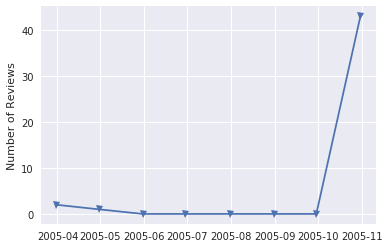

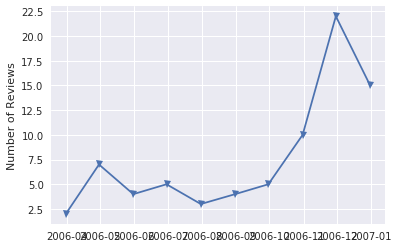

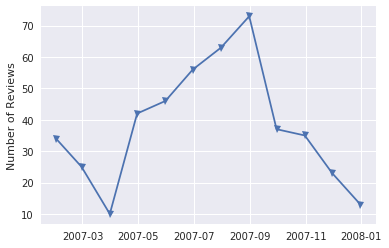

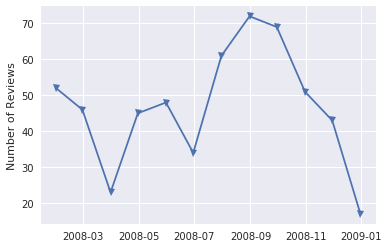

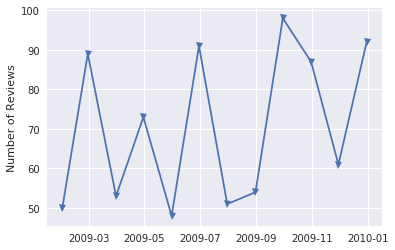

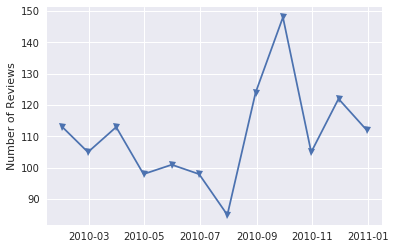

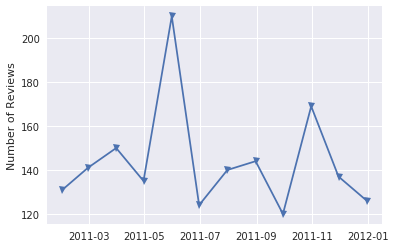

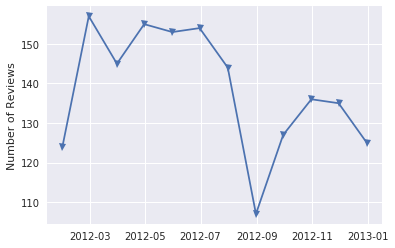

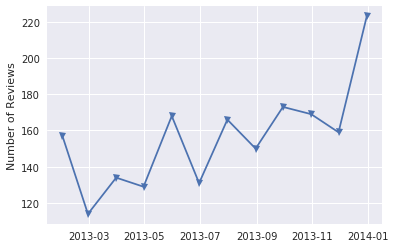

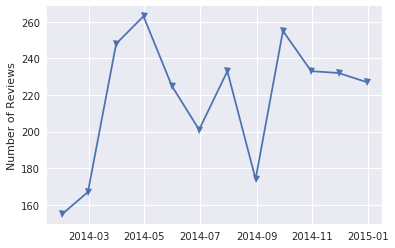

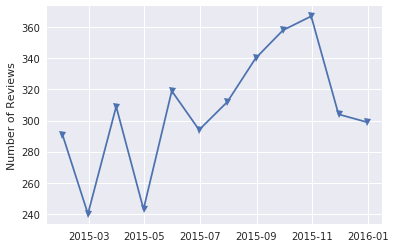

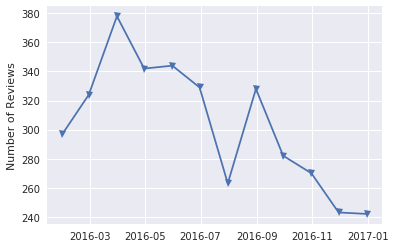

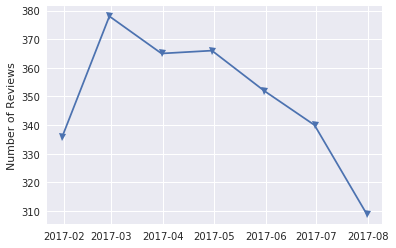

In [110]:
for i in range(2005,2017+1):
    year = str(i)
    plot(df[year])

# Recommendation
Based on our project we have found some useful information about our investment decision.
If we ignore the initial invest requirement and only focus on the information available, we could summarize our decisions as follows:
- The location of the business (From part 1 and part 4) is the Green Street or the downtown area in Champaign.
- The business type could be restaurant (from part 2).
- The restaurant type could be a smoke house and barbeque (from part 1).
- The best business model is the business model similar to the 'Black Dog Grilled & Ale House' (from Part 3).
- The best time to open the business is during July to September. (from Part 5).
 
Based on all these information, we strongly recommend investing in a smoke house restaurant with a business model similar to "Black Dog Grilled & Ale House during July to September in Champaign downtown or Green Street area.